In [15]:
import numpy as np # Funciones numéricas
import pandas as pd # Manejo de bases de datos
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Geo análisis
import geopandas as gpd
import libpysal
import mapclassify

# Importa las librerias para los calculos de correlación espacial
from libpysal.weights.contiguity import Queen

# Moran global
from esda.moran import Moran

# Moran local
from esda.moran import Moran_Local

# Graficos de moran
from splot.esda import moran_scatterplot
from splot.esda import plot_moran
from splot.esda import plot_local_autocorrelation
from splot.esda import lisa_cluster

# Widgets interactivos
import ipywidgets as widgets

from ipywidgets import AppLayout, Layout, HTML, VBox, HBox
from IPython.display import clear_output
#from palettable import colorbrewer

%matplotlib inline

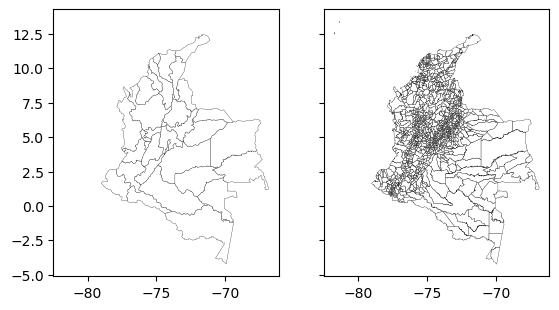

In [16]:
#Carga los shapes de departamento y municipio
#ruta_shapes = "../../MGN_2021_COLOMBIA/ADMINISTRATIVO/"
#ruta_shapes = "../shape_files/Colombia/ADMINISTRATIVO/"
#shape_dpto = gpd.read_file(ruta_shapes + "MGN_DPTO_POLITICO.shp")
#shape_mpio = gpd.read_file(ruta_shapes + "MGN_MPIO_POLITICO.shp")

#ruta_shapes = "../../MGN_2021_COLOMBIA/ADMINISTRATIVO/"
ruta_shapes = "Shape_files/Colombia/Administrativo/"
shape_dpto = gpd.read_file(ruta_shapes + "MGN_AMN_DPTOS.topojson")
#shape_mpio = gpd.read_file(ruta_shapes + "MGN_AMN_MPIOS.topojson")
shape_mpio = gpd.read_file(ruta_shapes + "Colombia_departamentos_municipios_CNPV2018.topojson")

# crea dos subplots con ejes compartidos
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
shape_dpto.plot(color='white', edgecolor='black', ax = ax1, linewidth=0.2)
shape_mpio.plot(color='white', ax = ax2, linewidth=0.2, edgecolor='black', facecolor='white')
#shape_mpio.plot(ax=);
plt.show();

# calcula la matriz de contiguidad
w_dpto = Queen.from_dataframe(shape_dpto.loc[shape_dpto['DPTO_CCDGO'] != '88', ['DPTO_CCDGO', 'geometry']])
w_dpto.transform = 'r'

w_mpio = Queen.from_dataframe(shape_mpio.loc[shape_mpio['DPTO_CCDGO'] != '88', ['MPIO_CDPMP', 'geometry']])
w_mpio.transform = 'r'

In [17]:
print(shape_mpio.crs)

None


In [18]:
# Leer el archivo fuente
path = "Datos/"
file = "datos_mm_cancer.csv"
data = pd.read_csv(path + file, sep=";", encoding= "cp1252",
                   decimal=",", thousands=".")
data['Tipo_cancer'] = data['Tipo_cancer'].str.replace('_invasivo', '', regex=False)

# limpiamos caracteres sombrantes de las columnas de texto
for i in data.select_dtypes(include=['object']).columns:
    data[i] = data[i].str.strip()

#cargamos el archivo con los nomrbes iso y lo agregamos
nombre_iso = pd.read_csv(path + "nombres_iso_dptos.csv", sep=";", encoding= "cp1252",
                         dtype={"Codigo_departamento":str})
display(data.head())
#display(nombre_iso.head())

,Año,Tipo_cancer,Indicador,Categoria,Etiqueta,Numerador,Denominador,Valor_crudo,Valor_ajustado,Tipo
0,2018,Mama,Mortalidad,Nacional,Colombia,2498,24953862,10.010475,10.010475,Morbimortalidad
1,2018,Mama,Mortalidad,Región,Bogotá D.C.,430,4167824,10.317134,9.676866,Morbimortalidad
2,2018,Mama,Mortalidad,Región,Atlántica,507,5328956,9.514059,10.873703,Morbimortalidad
3,2018,Mama,Mortalidad,Región,Central,687,5507205,12.474567,11.774871,Morbimortalidad
4,2018,Mama,Mortalidad,Región,Oriental,389,4980341,7.810710,7.624844,Morbimortalidad


In [19]:
def grafico_coropleta_cat(data, cancer, indicador, nivel, variable):
    """ Esta función realizar el gráfico de coropleta de la variable de interes por el nivel sele
    parametros
    cancer = texto del tipo de cancer para filtrar la base
    indicador = texto del indicador a analizar ('Mortalidad', 'PCNR', 'Prevalencia' )
    nivel = texto nivel geografico del gráfico ('Departamento', 'Municipio')
    Variable = texto del nombre de variable a graficar. La variable debe ser numérica
    """
    #Validaciones
    if (cancer not in list(data['Tipo_cancer'].unique())):
        print("El tipo de cáncer solo toma las valores:" + str(data['Tipo_cancer'].unique()))
        return
    elif (indicador not in list(data['Indicador'].unique())):
        print("El Indicador solo toma las valores:" + str(data['Indicador'].unique()))
        return
    #elif (variable not in ['Valor_crudo', 'Valor_ajustado']):
    #    print("La variable debe estar entre: " + str(['Valor_crudo', 'Valor_ajustado']))
    #    return
    elif (nivel not in ['Departamento', 'Municipio']):
        print("El parámetro Nivel solo puede tomar los valores Departamento o Municipio")
        return

    # Crea el dataframe del gráfico
    df = data.loc[(data["Tipo_cancer"] == cancer) &
                  (data["Indicador"] == indicador) &
                  (data["Categoria"] == nivel)].copy()
    
    if nivel == "Departamento":
        df_gra = df.copy()
        df_gra['geo_code'] = [x[:2] for x in df_gra['Etiqueta']] 
        shape_grafico = shape_dpto.copy()
        shape_grafico['geo_code'] = shape_grafico['DPTO_CCDGO']
        color = 'k'
    else:
        df_gra = df.copy()
        df_gra['geo_code'] = [x[:5] for x in df_gra['Etiqueta']]
        shape_grafico = shape_mpio.copy()
        shape_grafico['geo_code'] = shape_grafico['MPIO_CDPMP']
        color = None

    fig, ax = plt.subplots()
    #fig.subplots_adjust(bottom=0.025, left=0.025, top = 0.975, right=0.975)
            
    #crear el dataset temporal
    if nivel == "Municipio":
            shape_dpto.plot(ax=ax, edgecolor='k', figsize=(5,4))
        
    d = df_gra.query("Año == "+ str(2021)).copy()
    c = shape_grafico.merge(d[['geo_code', variable]],
                                how='left',
                                on='geo_code').copy()
    c.fillna({variable:0}, inplace=True)
    c['cero'] = ['Igual a cero' if x == 0 else "Mayor que cero" for x in c[variable]]

    
    #diccionario de color
    ClusterPalette = {'Mayor que cero': '#E0E0E0',
                      'Igual a cero': '#BD0026'}


    # Loop through each attribute type and plot it using the colors assigned in the dictionary
    for ctype, datos in c.groupby('cero'):
    
        # Define the color for each group using the dictionary
        color_grupo = ClusterPalette[ctype]

        # Plot each group using the color defined above
        datos.plot(ax=ax, 
                   color = color_grupo,
                   label = ctype,
                   edgecolor = color, figsize=(5,4))
    
    # Crea los elementos de la legenda, son los items del diccionario de colores
    legend_elements = [Line2D([0], [0], marker='o', 
                                        color='w', 
                                        markerfacecolor = v, 
                                        label = k, 
                                        markersize=8) 
                       for k, v in ClusterPalette.items()]

    # Inserta la leyenda
    ax.legend(handles=legend_elements,
              ncol=1,
              prop={'size': 8}, 
              bbox_to_anchor=(0.83, 0.99), 
              loc='upper center',
              shadow=True, 
              frameon=True,
              edgecolor='k')

    
    #ax.set_title("Año " + str(2021), fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    
    titulo = "Lugares con valor cero en la varible " + variable.lower().replace("_", " ")
    ax.set_title(titulo, fontsize=10)#, fontweight="bold")
    
    #fig.tight_layout()
    plt.show()

In [20]:
# Define la función para realizar el gráfico de barras de la variable de interes bien
def grafico_barra(data, cancer, indicador, nivel, variable, año, multiplicador):
    """ Esta función recibe realizar el gráfico de barras de la variable de interes bien sea por departamento o por municipio
    parametros
    cancer = texto del tipo de cancer para filtrar la base
    indicador = texto del indicador a analizar ('Mortalidad', 'PCNR', 'Prevalencia' )
    nivel = texto nivel geografico del gráfico ('Departamento', 'Municipio')
    multiplicador = texto que indica el valor por el cual está expresado el indicador (100, 1000, 1000, ..., etc)
    Variable = texto del nombre de variable a graficar. La variable debe ser numérica
    """
    df = data.loc[(data["Tipo_cancer"] == cancer) &
                  (data["Indicador"]== indicador) &
                  ((data["Categoria"]== nivel) | (data["Categoria"]== "Nacional"))].copy()

    if nivel == 'Departamento':
        # Extraemos el nombre de dpto o región para el label del grafico
        df['Cod_dpto'] = [x[:2] for x in df['Etiqueta']]
        df = df.merge(nombre_iso[['Codigo_departamento', 'Nombre_corto']],
                      how="left",
                      left_on="Cod_dpto", right_on="Codigo_departamento")
        df = df.rename(columns={'Nombre_corto':'Nombre'})
        df.loc[df['Categoria'] == 'Nacional', 'Nombre'] = 'COL'
        
    else:
        # Extraemos el nombre de dpto o región para el label del grafico
        df['Nombre'] = [x[:2]+"-"+ x[6:] for x in df['Etiqueta']]
        df.loc[df['Categoria'] == 'Nacional', 'Nombre'] = 'Colombia'
    

    if type(multiplicador) != str:
        multiplicador = str(multiplicador)
    
    #ordenamos por año y prevalencia ajustada
    df = df.sort_values(by=['Año', variable], ascending = [True, False])
    
    #Hacemos el grafico
    fig, ax = plt.subplots(figsize=(5,4))
    #fig.subplots_adjust(bottom=0.025, left=0.025, top = 0.975, right=0.975)

    d = df.query("Año == "+ str(año)).copy()
    c = df.query("Año == "+ str(año) + " & Etiqueta=='Colombia'").copy()
    if nivel == 'Municipio':
        d = d.iloc[:19,:]
            
    ax.bar(d["Nombre"], d[variable])
    ax.bar(c["Nombre"], c[variable], color = 'red')
    ax.tick_params(axis='x', rotation=90) #, labelsize=12)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.axhline(np.array(c[variable]), color='r', linewidth=2)
    
    #ax.set_title("Año " + str(año), fontsize=10)
    #subtitulo = indicador + " de cancer de " + cancer + " x " + multiplicador + " a nivel " + nivel
    #plt.suptitle(subtitulo, fontsize=14, fontweight="bold")
    fig.tight_layout()
    
    plt.show()

In [21]:
# Define la función para realizar el gráfico de densidad de kernel de la variable de interes
def grafico_kde(data, cancer, indicador, nivel, variable, año, multiplicador):
    """ Esta función realiza el gráfico de densidad de kernel de la variable de interes por el nivel selecionado
        parametros
        cancer = texto del tipo de cancer para filtrar la base
        indicador = texto del indicador a analizar ('Mortalidad', 'PCNR', 'Prevalencia' )
        nivel = texto nivel geografico del gráfico ('Departamento', 'Municipio')
        multiplicador = texto que indica el valor por el cual está expresado el indicador (100, 1
        Variable = texto del nombre de variable a graficar. La variable debe ser numérica
    """
    if type(multiplicador) != str:
        multiplicador = str(multiplicador)
        
    # Crea el dataframe del gráfico
    df = data.loc[(data["Tipo_cancer"] == cancer) &
                  (data["Indicador"] == indicador) &
                  (data["Categoria"] == nivel) & 
                  (data["Año"] == año)].copy()
    
    fig, ax = fig, ax = plt.subplots()
    # Configura el grafico
    ax = sns.kdeplot(data=df, x=variable, fill=True)
    
    plt.ylabel("Densidad")
    #plt.xlabel(variable)
    
    # Ajusta los titulos
    #titulo = "Distribución kernel de " + indicador + " de cáncer de " + cancer + " por " + multiplicador + " a nivel " + nivel
    #plt.title(titulo , fontsize=10, fontweight="bold", y=1.15)
    
    plt.show()

In [22]:
def grafico_coropleta(data, cancer, indicador, nivel, variable, año, esquema='Quantiles', grupos=4):
    """ Esta función realizar el gráfico de coropleta de la variable de interes por el nivel sele
    parametros
    cancer = texto del tipo de cancer para filtrar la base
    indicador = texto del indicador a analizar ('Mortalidad', 'PCNR', 'Prevalencia' )
    nivel = texto nivel geografico del gráfico ('Departamento', 'Municipio')
    Variable = texto del nombre de variable a graficar. La variable debe ser numérica
    """
    # Crea el dataframe del gráfico
    df = data.loc[(data["Tipo_cancer"] == cancer) &
                  (data["Indicador"] == indicador) &
                  (data["Categoria"] == nivel)].copy()
    
    if nivel == "Departamento":
        df_gra = df.copy()
        df_gra['geo_code'] = [x[:2] for x in df_gra['Etiqueta']] 
        shape_grafico = shape_dpto.copy()
        shape_grafico['geo_code'] = shape_grafico['DPTO_CCDGO']
        color = 'k'
    else:
        df_gra = df.copy()
        df_gra['geo_code'] = [x[:5] for x in df_gra['Etiqueta']]
        shape_grafico = shape_mpio.copy()
        shape_grafico['geo_code'] = shape_grafico['MPIO_CDPMP']
        color = None

    fig, ax = plt.subplots()

    #crear el dataset temporal
    if nivel == "Municipio":
        shape_dpto.plot(ax=ax, edgecolor='k', figsize=(5,4))
        
    d = df_gra.query("Año == "+ str(año)).copy()
    c = shape_grafico.merge(d[['geo_code', variable]],
                            how='left',
                            on='geo_code').copy()
    c.fillna({variable:0}, inplace=True)
        
    # calcula el número de grupos
    grupos = len(mapclassify.classify(c[variable].values, scheme = esquema.lower(), k=grupos).bins)
    
    c.plot(ax=ax, column = variable, figsize=(5,4),
           scheme = esquema, k = grupos,
           cmap='YlOrRd', legend=True,
           edgecolor = color,
           legend_kwds = {'ncol':1,
                          'bbox_to_anchor':(0.8, 0.95),
                          'loc':'upper center',
                          'shadow':True,
                          'frameon':True,
                          'fmt':"{:.0f}", 'interval':True,
                          'edgecolor':'k',
                          'fontsize':7})
        
    #ax.set_title("Año " + str(año), fontsize=10)
    #ax[col].axis('off')
    ax.set_xticks([])
    ax.set_yticks([])
        
    #titulo = indicador + " de cáncer de " + cancer + " a nivel " + nivel + " por " + esquema + " dividido en " + str(grupos) + " grupos"
    titulo = "Gráfico de coropletas dividido en " + str(grupos) + " grupos"
    plt.title(titulo, fontsize=10) #, fontweight="bold")
    ax.autoscale()
    #fig.tight_layout()
    
    #plt.savefig("../Salidas/" + "Gr_coropleta_" + cancer + "_" + indicador + "_" + nivel + "_" + variable + ".png", format='png', bbox_inches = 'tight');
    plt.show()

In [23]:
# moran Scatter unificado por año
def moran_global_local(data, cancer, indicador, nivel, variable, año = 2021, esquema = 'Quantiles', grupos = 5, grafico = 'scatter'):
    """ Esta función realizar el gráfico de coropleta de la variable de interes por el nivel seleccionado
    parametros
    cancer = texto del tipo de cancer para filtrar la base
    indicador = texto del indicador a analizar ('Mortalidad', 'PCNR', 'Prevalencia' )
    nivel = texto nivel geografico del gráfico ('Departamento', 'Municipio')
    Variable = texto del nombre de variable a graficar. La variable debe ser numérica
    """
    # Crea el dataframe del gráfico
    df = data.loc[(data["Tipo_cancer"] == cancer) &
                  (data["Indicador"] == indicador) &
                  (data["Categoria"] == nivel) &
                  (data["Año"] == año)].copy()
                       
    if nivel == 'Departamento':
        # Crea el código geográfico y deja solo las columnás útiles
        df['geo_code'] = [x[:2] for x in df['Etiqueta']]
        df = df[["geo_code", "Numerador", "Denominador", "Valor_crudo", "Valor_ajustado"]]

        # Carga el shape correspondiente y le pega los datos (Excluye San andrés del cálculo de c
        shape_corr = shape_dpto.loc[shape_dpto['DPTO_CCDGO'] != '88', ['DPTO_CCDGO', 'geometry']]
        shape_corr['geo_code'] = shape_corr['DPTO_CCDGO']
        shape_corr = shape_corr.merge(df[['geo_code', variable]], how = 'left', on = 'geo_code')
        shape_corr.fillna(0, inplace=True)
        color = 'k'
        w = w_dpto
    else:
        # Crea el código geográfico y deja solo las columnás útiles
        df['geo_code'] = [x[:5] for x in df['Etiqueta']]
        df = df[["geo_code", "Numerador", "Denominador", "Valor_crudo", "Valor_ajustado"]]

        # Carga el shape correspondiente y le pega los datos (Excluye San andrés del cálculo de c
        shape_corr = shape_mpio.loc[shape_mpio['DPTO_CCDGO'] != '88', ['MPIO_CDPMP', 'geometry']]
        shape_corr['geo_code'] = shape_corr['MPIO_CDPMP']
        shape_corr = shape_corr.merge(df[['geo_code', variable]], how = 'left', on = 'geo_code')
        shape_corr.fillna(0, inplace = True)
        color = None
        w = w_mpio
                       
    # calcula el indice global de moran
    moran = Moran(shape_corr[variable], w)
    
    # calcula el indice local (Local Indicators of Spatial Association - LISAs)
    lisa = Moran_Local(shape_corr[variable], w)
    lisa_porcentaje = (lisa.p_sim < 0.05).sum() * 100 / len(lisa.p_sim)
    
    # Break observations into significant or not
    shape_corr['significant'] = lisa.p_sim < 0.05
    
    # Store the quadrant they belong to
    shape_corr['quadrant'] = lisa.q
    
    #preparamos los colores para el mapa de clusters en la base del shape
    shape_corr.loc[shape_corr['significant']==False, 'grupo'] = 'ns' # etiquetamos clusters no
    shape_corr.loc[(shape_corr['quadrant']==1) & (shape_corr['significant']==True), 'grupo'] = 'HH'
    shape_corr.loc[(shape_corr['quadrant']==3) & (shape_corr['significant']==True), 'grupo'] = 'LL'
    shape_corr.loc[(shape_corr['quadrant']==2) & (shape_corr['significant']==True), 'grupo'] = 'LH'
    shape_corr.loc[(shape_corr['quadrant']==4) & (shape_corr['significant']==True), 'grupo'] = 'HL'

    
    if grafico == 'scatter':
        scatter_lisa(lisa, moran, variable)
    
    if grafico == 'cluster':
        mapa_cluster(shape_corr, lisa_porcentaje, nivel)
    # Elaboramos las graficas
    return

In [24]:
def scatter_lisa(lisa, moran, variable):
    fig, ax = plt.subplots(figsize=(5,4))
    
    # Gráfico de dispersión de moran
    moran_scatterplot(lisa, p=0.05, ax=ax, aspect_equal=False)
    ax.set_xlabel(variable.replace("_", " "))
    ax.set_title("Indice de Moran global = " + str(round(moran.I,3)) + "\n P value = " + str(round(moran.p_sim,3)),
                 fontsize = 10)
    
    ax.set_autoscale_on(False)
    plt.ylim(-0.5,1)
    
    ax.spines[:].set_color("k")
    fig.tight_layout()
    plt.show()

In [25]:
def mapa_cluster(shape, lisa_porcentaje, nivel):
    fig, ax = plt.subplots()

    #diccionario de color
    ClusterPalette = {'ns': '#E0E0E0',
                      'HH': '#BD0026',
                      'LL': '#08306B',
                      'LH': '#6BAED6',
                      'HL': '#FD8D3C'}

    # Loop através de cada through each attribute type and plot it using the colors assigned in the dictionary
    for ctype, datos in shape.groupby('grupo'):
        # Define the color for each group using the dictionary
        color_grupo = ClusterPalette[ctype]
        # Plot each group using the color defined above
        datos.plot(color=color_grupo,
                   ax=ax,
                   label=ctype, figsize=(5,4))
                                                                                             
    # Crea los elementos de la legenda, son los items del diccionario de colores
    legend_elements = [Line2D([0], [0], 
                              marker='o', 
                              color='w',
                              markerfacecolor=v, 
                              label=k, markersize = 8) for k, v in ClusterPalette.items()]
    # Inserta la leyenda
    ax.legend(handles=legend_elements,
              ncol=1,
              prop={'size': 8},
              bbox_to_anchor=(0.8, 0.95),
              loc='upper center',
              shadow=True,
              frameon=True,
              edgecolor='k')

    # Escribe la nota al pie del gráfico
    #ax.annotate(str(round(lisa_porcentaje, 1)) + "% de " + nivel +"s hacen parte de un cluster espacial",
    #            xy=(10, 10), xycoords='axes pixels', fontsize=8)
    

    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_title("Clusters espaciales", fontsize=10)
    #subtitulo = "Resultados para la " + indicador + " de cáncer de " + cancer + " por " + nivel + " del año " + str(año)
    #plt.suptitle(subtitulo, fontsize=14, fontweight="bold")
    #fig.tight_layout()
    
    #plt.savefig("../Salidas/" + "Gr_moran_" + cancer + "_" + indicador + "_" + nivel + "_" + variable + str(año) + ".png", format='png', bbox_inches = 'tight');
    plt.show()

In [26]:
#widget de Tipo de cancer
wdg_cancer = widgets.Dropdown(
    options = data["Tipo_cancer"].unique(),
    value = data["Tipo_cancer"].unique()[0],
    description='Cáncer:',
    disabled=False,
    layout=Layout(width='250px'))

#widget de Indicador
wdg_indicador = widgets.Dropdown(
    options = data["Indicador"].unique(),
    value = data["Indicador"].unique()[0],
    description='Indicador:',
    disabled=False,
    layout=Layout(width='250px'))

# Años
wdg_años = widgets.Dropdown(
    options = np.sort(data["Año"].unique())[::-1],
    value = np.sort(data["Año"].unique())[::-1][0],
    description='Año:',
    disabled=False,
    layout=Layout(width='250px'))

# Nivel
wdg_nivel = widgets.Dropdown(
    options = ['Departamento', 'Municipio'],
    value = 'Departamento',
    description='Nivel:',
    disabled=False,
    layout=Layout(width='250px'))

# variable
wdg_variable = widgets.Dropdown(
    options = ['Numerador', 'Denominador', 'Valor_crudo', 'Valor_ajustado'],
    value = 'Numerador',
    description='Variable:',
    disabled=False,
    layout=Layout(width='250px'))

def on_button_clicked(b):
    
    titulo = (wdg_indicador.value + " de cáncer de " + str(wdg_cancer.value).lower()    + 
              " a nivel " + str(wdg_nivel.value).lower() + " en el año " + str(wdg_años.value))
    header.value = "<h1 style='text-align:center'>" + titulo + "</h1>"
    
    with salida_valor_cero:
        clear_output(wait=False,)
        grafico_coropleta_cat(data      = data,
                              cancer    = wdg_cancer.value,
                              indicador = wdg_indicador.value,
                              nivel     = wdg_nivel.value,
                              variable  = wdg_variable.value)
        fig.tight_layout()
        
    with grp_barras:
        clear_output(wait=False,)
        grafico_barra(data      = data,
                      cancer    = wdg_cancer.value,
                      indicador = wdg_indicador.value,
                      nivel     = wdg_nivel.value,
                      variable  = wdg_variable.value,
                      año       = wdg_años.value,
                      multiplicador = '100.000')
        fig.tight_layout()
        
    with grp_kde:
        clear_output(wait=False,)
        grafico_kde(data      = data,
                   cancer    = wdg_cancer.value,
                   indicador = wdg_indicador.value,
                   nivel     = wdg_nivel.value,
                   variable  = wdg_variable.value,
                   año       = wdg_años.value,
                   multiplicador = '100.000')
        fig.tight_layout()
        
    with grp_scatter:
        clear_output(wait=False,)        
        moran_global_local(data      = data,
                          cancer    = wdg_cancer.value,
                          indicador = wdg_indicador.value,
                          nivel     = wdg_nivel.value,
                          variable  = wdg_variable.value,
                          año       = wdg_años.value,
                          esquema   = 'Quantiles',
                          grupos    = 4,
                          grafico   = 'scatter')   
        fig.tight_layout()
        
    with grp_coro:
        clear_output(wait=False,)        
        grafico_coropleta(data      = data,
                          cancer    = wdg_cancer.value,
                          indicador = wdg_indicador.value,
                          nivel     = wdg_nivel.value,
                          variable  = wdg_variable.value,
                          año       = wdg_años.value,
                          esquema   = 'Quantiles',
                          grupos    =  4)   
        fig.tight_layout()
        
    with grp_cluster:
        clear_output(wait=False,)        
        moran_global_local(data      = data,
                          cancer    = wdg_cancer.value,
                          indicador = wdg_indicador.value,
                          nivel     = wdg_nivel.value,
                          variable  = wdg_variable.value,
                          año       = wdg_años.value,
                          esquema   = 'Quantiles',
                          grupos    = 4,
                          grafico   = 'cluster')   
        fig.tight_layout()

    
        
def cancer_change(change):
    wdg_indicador.options = data[data["Tipo_cancer"] == change["new"]]['Indicador'].unique() 

def indicador_change(change):
    wdg_años.options = data[(data["Tipo_cancer"] == wdg_cancer.value) & 
                       (data["Indicador"] == change["new"])]['Año'].unique() 
    
    wdg_años.value =  data[(data["Tipo_cancer"] == wdg_cancer.value) & 
                       (data["Indicador"] == change["new"])]['Año'].max() 
    
    if change["new"] in ['Detección temprana', 'Oportunidad tratamiento']:
            wdg_variable.options = ['Numerador', 'Denominador', 'Valor_crudo']
    else:
            wdg_variable.options = ['Numerador', 'Denominador', 'Valor_crudo', 'Valor_ajustado']

            
wdg_cancer.observe(cancer_change, names=["value"])
wdg_indicador.observe(indicador_change, names=["value"])

titulo = ('Seleccione los filtro y de click al botón "generar"')
header = HTML("<h1 style='text-align:center'>" + titulo + "</h1>", layout=Layout(width='auto'))

button = widgets.Button(description="Generar", button_style='info')
grp_barras = widgets.Output(layout=Layout(width='auto', height='auto'))
grp_kde = widgets.Output(layout=Layout(width='auto', height='auto'))
salida_valor_cero = widgets.Output(layout=Layout(width='auto', height='30%'))
grp_scatter = widgets.Output(layout=Layout(width='auto', height='auto'))
grp_coro= widgets.Output(layout=Layout(width='auto', height='30%'))
grp_cluster= widgets.Output(layout=Layout(width='auto', height='30%'))

button.on_click(on_button_clicked)

In [27]:
def create_expanded_button(description, button_style):
    return widgets.Button(description=description, button_style=button_style, layout=Layout(height='auto', width='auto'))

In [28]:
VBox([header,
      HBox([
          VBox([wdg_cancer, wdg_indicador, wdg_años, wdg_nivel, wdg_variable,button], 
                layout=Layout(align_items='center', width='20%', row_gap='20px')
              ),
               HBox([salida_valor_cero], layout=Layout(width='25%', hight='100%')), 
               HBox([grp_coro], layout=Layout(width='25%', hight='100%')),
               HBox([grp_cluster], layout=Layout(width='25%', hight='auto'))
      ], layout=Layout(align_items='stretch')
       ),
       HBox([widgets.Label('', layout=Layout(width='15%')), 
             HBox([grp_scatter], layout=Layout(width='25%', hight='100%')), 
             HBox([grp_barras], layout=Layout(width='25%', hight='100%')), 
             HBox([grp_kde], layout=Layout(width='25%', hight='100%'))
            ],
            layout=Layout(justify_content='space-around')
           )],
    layout=Layout(higth='auto', gap='10px'))